# 03_Classification_Models

Purpose of this notebook:
 - Read in the reddit posts
 - Build classifiers (models)
 - Evaluate models
    
 - Iterate!

# Imports and global notebook settings

In [1]:
# imports
import numpy as np
import pandas as pd
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, accuracy_score

from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter
import time

In [2]:
# Global options to increase rows and columns displayed
pd.set_option('display.max_columns', None)
# pd.reset_option(“max_columns”) # to reset back to limited columns
pd.set_option("max_rows", None)

## Read in data files

In [3]:
!ls ../posts

CallOfDuty_4000_2020-05-28_192353.csv callofduty_dnd_final.csv
DnD_4000_2020-05-28_192119.csv


In [4]:
# Read in file of posts
fname = '../posts/callofduty_dnd_final.csv'

In [5]:
# Create data frame
df_posts = pd.read_csv(fname)
df_posts.head(3)

,subreddit,author,num_comments,combo_post,b_subreddit
0,CallOfDuty,ant_thomas93,0,[BO2] got a question I tried MW2 for ages earl...,0
1,CallOfDuty,cameronlund08,0,"[COD] Most Populated COD’s? (XB1, MP) [removed]",0
2,CallOfDuty,aquang28,0,Death to the MPLA nan,0


In [6]:
df_posts.tail(3)

,subreddit,author,num_comments,combo_post,b_subreddit
7798,DnD,czubizzle,2,Music to help lighten up a TPK nan,1
7799,DnD,HasnainAshfaq12,0,Sugar ka Ilaj Diabetes Ka Khatma | Control Dia...,1
7800,DnD,Nickywynne,1,Crazy/Wacky/MinMax Warlock Builds So I love th...,1


## General Setup

In [7]:
# Check amount of data and class balance
print(f"Subreddit data : {df_posts.shape}")
df_posts['subreddit'].value_counts(normalize=True) 

Subreddit data : (7801, 5)


DnD           0.502115
CallOfDuty    0.497885
Name: subreddit, dtype: float64

In [8]:
# Programmatically get the subreddit names -- this generalizes the process
double_dictionary = dict()

codes = df_posts['b_subreddit'].value_counts().index
for code in codes:
    sr_name = list(df_posts[df_posts['b_subreddit']==code]['subreddit'].value_counts().index)[0]
    print(f"{code} means {sr_name}")
    double_dictionary[sr_name] = code
    double_dictionary[code] = sr_name
print(double_dictionary) # this allows me to look up either subreddit by name or value

1 means DnD
0 means CallOfDuty
{'DnD': 1, 1: 'DnD', 'CallOfDuty': 0, 0: 'CallOfDuty'}


In [9]:
# Baseline model is the % of the majority class; calculate and print
baseline_model = df_posts['subreddit'].value_counts(normalize=True).max()
print(f"Baseline model can predict correctly {100*baseline_model:.2f}% of the time.")

Baseline model can predict correctly 50.21% of the time.


## Text pre-processing

In [10]:
# Pieces of html links were not being removed by the vectorizers; remove them with regex
df_posts['cleaned_post'] = df_posts['combo_post'].apply(lambda x: re.sub('http[s]?://\S+', '', x)) # url
df_posts['cleaned_post'] = df_posts['cleaned_post'].apply(lambda x: re.sub('\\n','', x))           # \n newlines

In [11]:
# Add more terms to stopwords to remove give-away terms and see what else is important
stoppers = stopwords.words('english')

exclude_also = ['nan',
               'amp','x200b',       # pieces of url or formatting
               'cod','bo','bo1','bo2','bo3',        # game tags
                # All models at 93% before removing additional terms
               'xbox','duty','call',   # get to the next level
               'modern','warfare',     # edition of CoD
               'mw','m2','mw2','mw3','aw','ps3',
               'dnd','5e',
               'one','would','removed'
               ]
stoppers = stoppers + exclude_also
stoppers[-9:]

['mw2', 'mw3', 'aw', 'ps3', 'dnd', '5e', 'one', 'would', 'removed']

# Models

## 0. Common setup for all models

In [12]:
# Models require a binary target
y = df_posts['b_subreddit']

In [13]:
# Text columns to be used in classification
X = df_posts['cleaned_post']

In [14]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   stratify = y,
                                                   random_state=42) 

# random_state is set for repeatability in development and deployment

## 1. Classification Models
 - CountVectorizer + LogisticRegression
 - CountVectorizer + MultinomialNB       (NaiveBayes)
 - TfidfVectorizer + LogisticRegression

### 1. a) Set up pipes and hyperparameter grid searches

In [15]:
# Run once before model refinements, then comment out to avoid erasing the models to date
model_params = {}
count = 0
# Credit to Patrick Wales-Dinan for this tip -- and the code that follows to populate it

In [16]:
# Set up the pipes - note that each set of pipe_params was optimized individually

max_iterations = 1000  # to resolve ConvergenceWarnings

########### cv + logreg
pipe_TFIDF_SVC = Pipeline([
    ('tfidf', TfidfVectorizer()),   
    ('svc'  , SVC(max_iter=max_iterations))
])
pipe_params_TFIDF_SVC = {
    'tfidf__max_features': [800,1200,1400],           
    'tfidf__stop_words'  : [stoppers],     
    'tfidf__ngram_range' : [(1,2),(1,3)],         
    'svc__kernel'      : ['poly'],          
    'svc__degree'      : [2],              
    'svc__tol'         : [0.001],          # 0.001 is default and worked best
    'svc__C'           : [1]               # C=1 also worked best 
}

########### cv + logreg
pipe_CountVec_LR = Pipeline([
    ('cvec', CountVectorizer()),   
    ('lr'  , LogisticRegression(solver='liblinear',max_iter=max_iterations))
])

pipe_params_CountVec_LR = {
    'cvec__max_features':[800,1200,1400],       
    'cvec__stop_words' : [stoppers],             
    'cvec__ngram_range': [(1,3)],                
    'cvec__min_df'     : [20],                   
    'cvec__max_df'     : [.9],                  
    'lr__penalty'      : ['l1'],           # l1 (LASSO); ruled out 'l2'
    'lr__C'            : [1]               # C=1 was better
}

########## cv + multinomialNB
pipe_CountVec_MNB = Pipeline([
    ('cvec', CountVectorizer()),   
    ('mnb' , MultinomialNB())
])

pipe_params_CountVec_MNB = {
    'cvec__max_features': [800,1200,1400], 
    'cvec__stop_words'  : [stoppers],      
    'cvec__ngram_range' : [(1,2),(1,3)]    
}

########### tf + logreg
pipe_TFIDF_LR = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr'   , LogisticRegression(solver='liblinear',max_iter=max_iterations))
])

pipe_params_TFIDF_LR = {
    'tfidf__max_features': [800,1200,1400],      
    'tfidf__stop_words'  : [stoppers],           
    'tfidf__ngram_range' : [(1,3),(1,4),(1,5)],  
    'lr__penalty'        : ['l1'],               
    'lr__C'              : [1,10]                 
}

In [17]:
# Set up the grid searches
gs_tfsv = GridSearchCV(pipe_TFIDF_SVC,
                    pipe_params_TFIDF_SVC,
                    #n_jobs=-1,   # Causes UserWarning
                    #verbose=10,  # get status messages
                    cv=5)
gs_cvlr = GridSearchCV(pipe_CountVec_LR,
                    pipe_params_CountVec_LR,
                    #n_jobs=-1,   # Causes UserWarning
                    #verbose=100, # get status messages
                    cv=5)
gs_cvnb = GridSearchCV(pipe_CountVec_MNB,
                    pipe_params_CountVec_MNB,
                    #n_jobs=-1,   # Causes UserWarning
                    cv=5)
gs_tflr = GridSearchCV(pipe_TFIDF_LR,
                    pipe_params_TFIDF_LR,
                    #n_jobs=-1,  # Causes UserWarning
                    #verbose=1,  # get status messages   
                    cv=5)

### 1. b) Run searches and pipes

In [18]:
# Optionally turn off warnings once the models are producing good results
#   non convergence may mean the result is not perfect, but it might be good enough
simplefilter("ignore", category=ConvergenceWarning)

In [19]:
# Fit gridsearch to the training data
t0 = time.time()
gs_tfsv_output = gs_tfsv.fit(X_train, y_train)
# n_jobs causes 
# UserWarning: A worker stopped while some jobs were given to the executor.
print(f"This took {time.time() - t0:.02f} seconds to run")

print(gs_tfsv.best_score_)

# Add results to the model list
count += 1
gs_tfsv.best_params_['score'] = gs_tfsv.best_score_         
model_params[f'model_{count}_tfsv'] = gs_tfsv.best_params_ 

# Optionally look at the output from the fit (uncomment to view)
# gs_cvlr_output

This took 40.16 seconds to run
0.9092307692307692


In [20]:
# Fit gridsearch to the training data
t0 = time.time()
gs_cvlr_output = gs_cvlr.fit(X_train, y_train)
# n_jobs causes 
# UserWarning: A worker stopped while some jobs were given to the executor.
print(f"This took {time.time() - t0:.02f} seconds to run")

print(gs_cvlr.best_score_)

# Add results to the model list
count += 1
gs_cvlr.best_params_['score'] = gs_cvlr.best_score_         
model_params[f'model_{count}_cvlr'] = gs_cvlr.best_params_ 

# Optionally look at the output from the fit (uncomment to view)
# gs_cvlr_output

This took 14.46 seconds to run
0.9143589743589743


In [21]:
# Uncomment to view - best options summarized above during optimization / iteration phase
# gs_cvlr.best_params_

In [22]:
# Fit gridsearch to the training data
t0 = time.time()
gs_cvnb_output = gs_cvnb.fit(X_train, y_train)
print(f"This took {time.time() - t0:.02f} seconds to run")

print(gs_cvnb.best_score_)

# Add results to the model list
count += 1
gs_cvnb.best_params_['score'] = gs_cvnb.best_score_         
model_params[f'model_{count}_cvnb'] = gs_cvnb.best_params_ 

# Optionally look at the output from the fit (uncomment to view)
# gs_cvnb_output

This took 22.39 seconds to run
0.8598290598290598


In [23]:
# Uncomment to view - best options summarized above during optimization / iteration phase
# gs_cvnb.best_params_

In [24]:
t0 = time.time()
gs_tflr_output = gs_tflr.fit(X_train, y_train)
print(f"This took {time.time() - t0:.02f} seconds to run")

print(gs_tflr.best_score_)

# Add results to the model list
count += 1
gs_tflr.best_params_['score'] = gs_tflr.best_score_         
model_params[f'model_{count}_tflr'] = gs_tflr.best_params_ 

This took 130.68 seconds to run
0.914017094017094


In [25]:
# Uncomment to view - best options summarized above during optimization / iteration phase
# gs_tflr.best_params_

### 1. c) Compare results

In [26]:
# Put model stats in a DataFrame; review
cols = ['cvec__max_features','tfidf__max_features','cvec__ngram_range','tfidf__ngram_range',
        'lr__C','svc__C','score']
model_df = pd.DataFrame.from_dict(model_params, orient='index')[cols]
model_df

,cvec__max_features,tfidf__max_features,cvec__ngram_range,tfidf__ngram_range,lr__C,svc__C,score
model_1_tfsv,NaN,1400.0,NaN,"(1, 3)",NaN,1.0,0.909231
model_4_tflr,NaN,1400.0,NaN,"(1, 3)",10.0,NaN,0.914017
model_2_cvlr,1400.0,NaN,"(1, 3)",NaN,1.0,NaN,0.914359
model_3_cvnb,1400.0,NaN,"(1, 2)",NaN,NaN,NaN,0.859829


In [27]:
# Get the best results of the searches   # This is the mean cross-validated score of the best_estimator
print(f"gs_tfsv best score: {gs_tfsv.best_score_}")
print(f"gs_cvlr best score: {gs_cvlr.best_score_}")
print(f"gs_cvnb best score: {gs_cvnb.best_score_}")
print(f"gs_tflr best score: {gs_tflr.best_score_}")

gs_tfsv best score: 0.9092307692307692
gs_cvlr best score: 0.9143589743589743
gs_cvnb best score: 0.8598290598290598
gs_tflr best score: 0.914017094017094


In [28]:
# Get the best model from each search in order to score it on the test data
best_tfsv_model = gs_tfsv.best_estimator_
best_cvlr_model = gs_cvlr.best_estimator_
best_cvnb_model = gs_cvnb.best_estimator_
best_tflr_model = gs_tflr.best_estimator_

In [29]:
# Get the predictions and explore bias - note that these are not cross-validation scores...may look different
tfsv_train = best_tfsv_model.score(X_train, y_train)
tfsv_test  = best_tfsv_model.score(X_test, y_test)
tfsv_diff  = tfsv_train - tfsv_test

cvlr_train = best_cvlr_model.score(X_train, y_train)
cvlr_test  = best_cvlr_model.score(X_test, y_test)
cvlr_diff  = cvlr_train - cvlr_test

cvnb_train = best_cvnb_model.score(X_train, y_train)
cvnb_test  = best_cvnb_model.score(X_test, y_test)
cvnb_diff  = cvnb_train - cvnb_test

tflr_train = best_tflr_model.score(X_train, y_train)
tflr_test  = best_tflr_model.score(X_test, y_test)
tflr_diff  = tflr_train - tflr_test

In [30]:
# Print a small table of comparisons ready for a markdown cell
print(f"|Model|Vectorizer|Estimator|Train|Test|Difference|cv5|")
print(f"|---|---|---|---|---|---|---|")
print(f"|1|CountVectorizer|LogisticRegression|{cvlr_train:.4f}|{cvlr_test:.4f}|{cvlr_diff:.4f}|{gs_cvlr.best_score_:.4f}|")
print(f"|2|TfidfVectorizer|LogisticRegression|{tflr_train:.4f}|{tflr_test:.4f}|{tflr_diff:.4f}|{gs_tflr.best_score_:.4f}|")
print(f"|3|CountVectorizer|MultinomialNB|{cvnb_train:.4f}|{cvnb_test:.4f}|{cvnb_diff:.4f}|{gs_cvnb.best_score_:.4f}|")
print(f"|4|TfidfVectorizer|Support Vector Machine|{tfsv_train:.4f}|{tfsv_test:.4f}|{tfsv_diff:.4f}|{gs_tfsv.best_score_:.4f}|")

|Model|Vectorizer|Estimator|Train|Test|Difference|cv5|
|---|---|---|---|---|---|---|
|1|CountVectorizer|LogisticRegression|0.9535|0.9226|0.0309|0.9144|
|2|TfidfVectorizer|LogisticRegression|0.9764|0.9165|0.0600|0.9140|
|3|CountVectorizer|MultinomialNB|0.8740|0.8795|-0.0055|0.8598|
|4|TfidfVectorizer|Support Vector Machine|0.9844|0.9118|0.0726|0.9092|


**Discussion**

 - All models have very similar results. 
 - Predictions were slightly higher (93% accuracy) when none of the game keywords were removed.
 - The CountVectorizer + LogisticRegression is likely the most interpretable.

|Model|Vectorizer|Estimator|Train|Test|Difference|cv5|
|---|---|---|---|---|---|---|
|1|CountVectorizer|LogisticRegression|0.9535|0.9231|0.0304|0.9144|
|2|TfidfVectorizer|LogisticRegression|0.9764|0.9165|0.0600|0.9140|
|3|CountVectorizer|MultinomialNB|0.8740|0.8795|-0.0055|0.8598|
|4|TfidfVectorizer|Support Vector Machine|0.9844|0.9118|0.0726|0.9092|

In [31]:
# functions to work with TN, FP, FN, TP
def tfpn_to_metrics(model_name,TN,FP,FN,TP, verbose=False):
    if (verbose):
        print(f"\nSummary for {model_name} model:")
        print(f"    TN, FP, FN, TP:   {TN} {FP} {FN} {TP}")
        
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    precision = TP/(TP+FP)
    accuracy = (TP+TN)/(TP+FP+TN+FN)
    one_minus_spec = 1-specificity

    if (verbose):
        print(f"  sensitivity: {sensitivity:.4f}")
        print(f"  specificity: {specificity:.4f}")
        print(f"  precision:   {precision:.4f}")
        print(f"  accuracy:    {accuracy:.4f}")
    print(f"|{model_name}|{sensitivity:.4f}|{specificity:.4f}|{precision:.4f}|{accuracy:.4f}|")
    
    return one_minus_spec, sensitivity

def get_roc_points(model_name,estimator,X_test,y_true):
    y_pred = estimator.predict(X_test)
    TN, FP, FN, TP = confusion_matrix(y_true,y_pred).ravel()
    
    return tfpn_to_metrics(model_name, TN, FP, FN, TP)

In [32]:
def generate_baseline_roc(total_posts,baseline_model):
    TP = baseline_model*total_posts
    FP = (1-baseline_model) * total_posts
    FN = 0
    TN = 0
    
    return tfpn_to_metrics("Baseline model", TN, FP, FN, TP)

In [33]:
# Get the equivalent of a single point on the ROC curve for each model
x0,y0 = generate_baseline_roc(df_posts.shape[0], baseline_model)
x1,y1 = get_roc_points('Best CountVec - LogReg', best_cvlr_model,X_test,y_test)
x2,y2 = get_roc_points('Best TfidfVec - LogReg', best_tflr_model,X_test,y_test)
x3,y3 = get_roc_points('Best CountVec - MultiNB',best_cvnb_model,X_test,y_test)
x4,y4 = get_roc_points('Best TfidfVec - SVC'   , best_tfsv_model,X_test,y_test)

|Baseline model|1.0000|0.0000|0.5021|0.5021|
|Best CountVec - LogReg|0.8786|0.9670|0.9642|0.9226|
|Best TfidfVec - LogReg|0.8969|0.9361|0.9341|0.9165|
|Best CountVec - MultiNB|0.9214|0.8373|0.8511|0.8795|
|Best TfidfVec - SVC|0.8908|0.9331|0.9307|0.9118|


**Discussion**

Comparison of model performance: (game indicators removed)

|Model|Sensitivity | Specificity|Precision | Accuracy|
|---|---|---|---|---|
|Baseline model|1.0000|0.0000|0.5021|0.5021|
|Best CountVec - LogReg|0.8796|0.9670|0.9642|0.9231|
|Best TfidfVec - LogReg|0.8969|0.9361|0.9341|0.9165|
|Best CountVec - MultiNB|0.9214|0.8373|0.8511|0.8795|
|Best TfidfVec - SVC|0.8908|0.9331|0.9307|0.9118|

In [34]:
# ROC curve for cvlr model
arr = best_cvlr_model.predict_proba(X_test)
pred_1 = [x[1] for x in arr]
fpr_cvlr, tpr_cvlr, thresholds = roc_curve(y_test,pred_1)

In [35]:
# ROC curve for tflr model
arr = best_tflr_model.predict_proba(X_test)
pred_1 = [x[1] for x in arr]
fpr_tflr, tpr_tflr, thresholds = roc_curve(y_test,pred_1)

Text(0.5, 1.0, 'Model comparison - ROC curves')

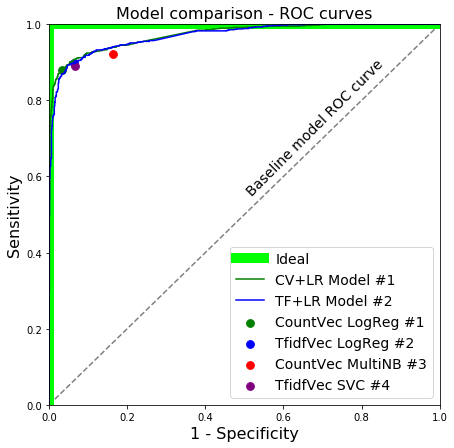

In [36]:
# Plot ROC curves
fig = plt.figure(figsize=(7,7))

# reference marks - ideal
ref = [0,1.0]
ref0 = [0,0]
ref1 = [1.0,1.0]
plt.plot(ref,ref, 'gray',linestyle='--', marker='')
plt.plot(ref0,ref, 'lime', linewidth=10, label='Ideal') # left edge
plt.plot(ref,ref1, 'lime', linewidth=10) # top edge


plt.plot(fpr_cvlr, tpr_cvlr, color='green',label = "CV+LR Model #1")
plt.plot(fpr_tflr, tpr_tflr, color='blue', label = "TF+LR Model #2")


# actual data
plt.scatter(x1,y1,label="CountVec LogReg #1",color='green',s=60) 
plt.scatter(x2,y2,label="TfidfVec LogReg #2",color='blue', s=60) 
plt.scatter(x3,y3,label="CountVec MultiNB #3",color='red', s=60)
plt.scatter(x4,y4,label="TfidfVec SVC #4",color='purple', s=60)

# reference marks - baseline
plt.text(.5, .55,"Baseline model ROC curve",rotation=45,fontsize=14)

# plot labels
plt.legend()
plt.ylabel("Sensitivity",fontsize=16)
plt.xlabel("1 - Specificity",fontsize=16)
plt.xlim(0,1)
plt.ylim(0,1)

plt.legend(fontsize=14);
plt.title('Model comparison - ROC curves',fontsize=16)

**Discussion**

These initial models all perform well.

For the models that use LogisticRegression, the predicted probabilities can be used to generate the ROC curve. 

For all models, if a confusion matrix can be generated, then there is sufficient information to calculate sensitivity and specificity for at least one decision threshold even if we don't know the threshold. Note that for the LogisticRegression models, this point falls on the ROC curve (as it should).

The green line (vertical on left, horizontal across the top) indicates the performance of an ideal model. While none of these models were ideal, they were all significantly better than the baseline.

## 2. Explore Key Contributors

There may be some keywords that make it easy to tell these subreddits apart, and the more interesting differences could be obscured by these. This section will look into these keywords and then possibly add them to the stop words and rerun the models.

Once a sufficient number of these 'give-away' terms are removed, the remaining words with high predictive strength may point to some differences in the two communities.

In [37]:
# CountVectorizer and LogisticRegression are the easiest to decipher
vectorizer = best_cvlr_model.named_steps['cvec']
classifier = best_cvlr_model.named_steps['lr']

In [38]:
# What was ignored? 
# These are terms that were ignored because they occured in 
#.     too many documents (max_df), 
#.     too few documents (min_df),
#.     or were cut off by feature selection (max_features)
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

list(vectorizer.stop_words_)[:9]  # just look at a few

['weapon color added',
 'skill challenge swallow',
 'lv2',
 'could feed young',
 'someone feeling',
 'warp leave',
 'creatures places',
 'killer demonic creature',
 'broken dresser']

In [39]:
# re-vectorize to explore word frequency
test_data_features = vectorizer.transform(df_posts['combo_post'])
vocab_df = pd.DataFrame(test_data_features.toarray(),
                          columns=vectorizer.get_feature_names())
print(f"vocab_df shape: {vocab_df.shape}")
# vocab_df.head(3)

vocab_df shape: (7801, 1328)


**Common Words**

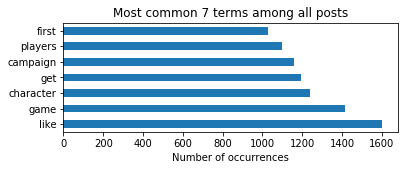

In [40]:
# Most common words in the posts
num_words = 7

if (num_words < 10):
    fig = plt.figure(figsize=(6,2))
else:
    fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(1,1,1)

vocab_df.sum().sort_values(ascending=False).head(num_words).plot(kind='barh',ax = ax)
title_str = "Most common " + str(num_words) + " terms among all posts"
ax.set_title(title_str)
ax.set_xlabel("Number of occurrences");

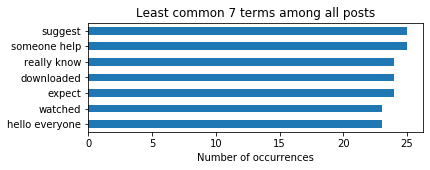

In [41]:
# Least common words in the posts
num_words = 7

if (num_words < 10):
    fig = plt.figure(figsize=(6,2))
else:
    fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(1,1,1)

vocab_df.sum().sort_values(ascending=True).head(num_words).plot(kind='barh',ax = ax)
title_str = "Least common " + str(num_words) + " terms among all posts"
ax.set_title(title_str)
ax.set_xlabel("Number of occurrences");

**Discussion**

The term "help" indicates that these subreddits may be frequented by people in search of help with issues rather than as a place for more general discussion.

It's unclear from a simple model that only uses tokenization whether 'like' is a positive sentiment (verb) or is used to make comparisons. This may be something to explore in a follow-up study.

In [42]:
# Check total number of posts
df_posts.shape

(7801, 6)

In [43]:
# Make masks for the subreddits
mask_sub1 = df_posts['b_subreddit'] == 1
mask_sub0 = df_posts['b_subreddit'] == 0

In [44]:
mask_sub1.sum() # how many posts will it select

3917

In [45]:
# Make separate lists of the vocab
vocab_df0 = vocab_df[mask_sub0].copy()
vocab_df1 = vocab_df[mask_sub1].copy()

In [46]:
vocab_df1.shape # confirm size matches above

(3917, 1328)

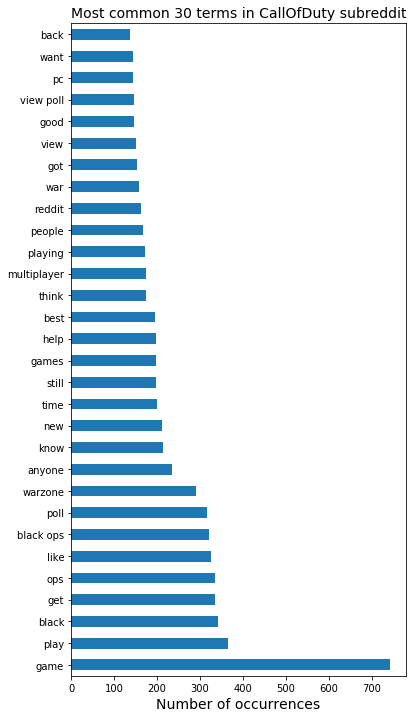

In [47]:
# Most common words in the posts

num_words = 30

if (num_words < 10):
    fig = plt.figure(figsize=(6,2))
else:
    fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(1,1,1)



vocab_df0.sum().sort_values(ascending=False).head(num_words).plot(kind='barh')

title_str = "Most common " + str(num_words) + " terms in " + double_dictionary[0]+ " subreddit"
ax.set_title(title_str, fontsize=14)
ax.set_xlabel("Number of occurrences", fontsize=14);

**Discussion**

 - The terms modern, warfare, mw, and mw2 were promininent on this list until placed in stop words. (The intent was to look for predictors other than the actual game names.)

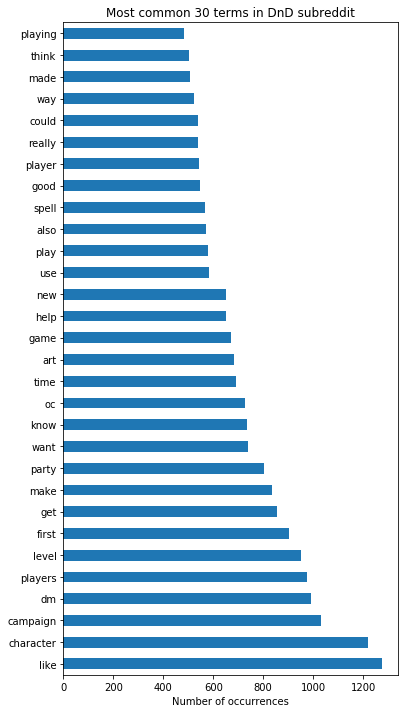

In [48]:
# Most common words in the posts
num_words = 30

if (num_words < 10):
    fig = plt.figure(figsize=(6,2))
else:
    fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(1,1,1)

vocab_df1.sum().sort_values(ascending=False).head(num_words).plot(kind='barh')

title_str = "Most common " + str(num_words) + " terms in " + double_dictionary[1]+ " subreddit"
ax.set_title(title_str)
ax.set_xlabel("Number of occurrences");

**Discussion**

 - Not surprising, but character and campaign rank near the top. This is likely explained by the way DnD has each player choose a character who joins others on a campaign. These are fundamental game mechanics.
 - The dm, or dungeon master, is also near the top of the list as is oc meaning 'original character'. These are also game mechanics.

In [49]:
# The list above is occurrences, but words that occur frequently in both categories 
#   are likely to be ignored by the vectorizer
# Check to see how many of these common words are in the vectorizer's stopwords
common = ['like','first','players','get','make','want','know',
         'one','like','would','level','way']

for cw in common:
    if cw in vectorizer.stop_words_:
        print(f"{cw} is in the stopwords (ignored)")
# interesting what was kept as having predictive value -- perhaps another round might see if they really provided
#    value or should be removed

In [50]:
# Check on how many posts each of these words shows up in for each subreddit
interesting = ['level','players','campaign','thanks']
for iword in interesting:
    print("\nStats for \'{}\': \n{}".format(iword,
        df_posts[df_posts['combo_post'].str.contains(iword)].groupby('subreddit')['subreddit'].count()))


Stats for 'level': 
subreddit
CallOfDuty     39
DnD           419
Name: subreddit, dtype: int64

Stats for 'players': 
subreddit
CallOfDuty     78
DnD           512
Name: subreddit, dtype: int64

Stats for 'campaign': 
subreddit
CallOfDuty     90
DnD           692
Name: subreddit, dtype: int64

Stats for 'thanks': 
subreddit
CallOfDuty    13
DnD           37
Name: subreddit, dtype: int64


**Discussion**

- My preconceived ideas of what differences would appear included the idea that the DnD players might be more accustomed to co-op play mode and that this might show up in how they interacted. The 37-to-13 ratio of the use of 'thanks' might be interesting to explore.
- The very high ration of 512-to-78 for the word 'players' seems very odd; both games require players! This might also be worth exploring.

**Best Words for Differentiating**

In [51]:
# Credits: Reem Mokhtar, for showing code so I could compare when my results were odd
# stackoverflow for confirming the correction to my code
# https://stackoverflow.com/questions/58165337/how-to-get-word-importance-in-nlp-tfidf-logistic-regression
# Reminder! use get_feature_names() not .vocabulary_ to match with coefficients

# Find the coefficients
feature_coefs = classifier.coef_[0]

# Find the features in the same order
feature_names = vectorizer.get_feature_names()

# Pair them up in a DataFrame

df_features = pd.DataFrame(feature_coefs, index=feature_names, columns=['beta_coef'])
df_features['exp_coef'] = df_features['beta_coef'].apply(lambda x: np.exp(x))
df_features.head()

,beta_coef,exp_coef
10,0.000000,1.000000
100,-0.853933,0.425737
11,-0.202387,0.816779
12,-0.039602,0.961172
13,0.000000,1.000000


In [52]:
# Highest exp_coef are strongly correlated with the '1' class
print(f"Highest correlations with {double_dictionary[1]}")
df_features.sort_values(by='exp_coef',ascending=False).head(20)


Highest correlations with DnD


,beta_coef,exp_coef
oc,5.332020,206.855482
art,4.861397,129.204566
dm,3.716613,41.124865
dice,3.655968,38.704986
bard,3.579510,35.855961
monster,3.459178,31.790842
homebrew,3.386214,29.553857
cleric,3.292903,26.920900
druid,3.139107,23.083252
warlock,3.090921,21.997324


In [53]:
# Lowest exp_coef are strongly correlated with the '0' class
print(f"Highest correlations with {double_dictionary[0]}")
df_features.sort_values(by='exp_coef',ascending=True).head(20)

Highest correlations with CallOfDuty


,beta_coef,exp_coef
warzone,-3.233675,0.039412
multiplayer,-3.054731,0.047135
ops,-2.718642,0.065964
remastered,-2.552993,0.077848
waw,-2.420123,0.088911
opinion,-2.068902,0.126324
lobby,-1.955830,0.141447
mission,-1.945426,0.142926
zombies,-1.917476,0.146977
wwii,-1.907772,0.148411


**Discussion**

 - The original list had a number of indicators of editions: bo, mw, mw2, mw3.
 - A suprising find is 'lobby'; this is a pre-game "warm-up" area for Call of Duty.
 - Both lists feature game mechanics promininently. Differences that show up in the first few that might be worth exploring include
  - Call of Duty: remastered and opinion
  - Dungeons and Dragons: art and homebrew
  - One hypothesis might be that DnD players have a more creative role to play in game and so they are thinking more creatively when talking about the game.

In [54]:
# Track down one of the posts that has a specific phrase
df_posts.loc[df_posts['combo_post'].str.contains('lobby'),['subreddit',
                                                            'cleaned_post']][:3]
# Looked this up and discovered that a lobby is a component of the game

,subreddit,cleaned_post
0,CallOfDuty,[BO2] got a question I tried MW2 for ages earl...
21,CallOfDuty,[MW2] can’t find lobbys Can’t find any lobbies...
22,CallOfDuty,MW2 lobby’s [removed]


In [55]:
# Query some raw data on these words
interesting = ['lore','elf','ranger','wizard','homebrew','party']
for iword in interesting:
    print("\nStats for \'{}\': \n{}".format(iword,
        df_posts[df_posts['combo_post'].str.contains(iword)].groupby('subreddit')['subreddit'].count()))


Stats for 'lore': 
subreddit
CallOfDuty     5
DnD           92
Name: subreddit, dtype: int64

Stats for 'elf': 
subreddit
CallOfDuty     46
DnD           303
Name: subreddit, dtype: int64

Stats for 'ranger': 
subreddit
DnD    66
Name: subreddit, dtype: int64

Stats for 'wizard': 
subreddit
DnD    143
Name: subreddit, dtype: int64

Stats for 'homebrew': 
subreddit
DnD    209
Name: subreddit, dtype: int64

Stats for 'party': 
subreddit
CallOfDuty      6
DnD           415
Name: subreddit, dtype: int64


**Discussion**

- Terms like 'elf' and 'lore' are usually associated more with a high fantasy game (DnD) versus a low fantasy game (CoD) but they do show up in the CoD subreddit.
- "Party" is a term often used for "group" in DnD, such as a "raiding party."

In [56]:
print(f"Reminder -- the baseline is {baseline_model} to predict {double_dictionary[1]}")

Reminder -- the baseline is 0.502115113446994 to predict DnD


In [57]:
# get the predictions
y_pred = best_cvlr_model.predict(X_test)

print(f"Summary for best_cv model:\n")

TN, FP, FN, TP = confusion_matrix(y_test,y_pred).ravel()
print(f"    TN, FP, FN, TP:   {TN} {FP} {FN} {TP}")
sensitivity = TP/(TP+FN)
specificity = TN/(TN+FP)
precision = TP/(TP+FP)
accuracy = (TP+TN)/(TP+FP+TN+FN)


print(f"  sensitivity: {sensitivity:.4f}")
print(f"  specificity: {specificity:.4f}")
print(f"  precision:   {precision:.4f}")
print(f"  accuracy:    {accuracy:.4f}")
print(f"|best_cvlr|{sensitivity:.4f}|{specificity:.4f}|{precision:.4f}|{accuracy:.4f}|")

Summary for best_cv model:

    TN, FP, FN, TP:   939 32 119 861
  sensitivity: 0.8786
  specificity: 0.9670
  precision:   0.9642
  accuracy:    0.9226
|best_cvlr|0.8786|0.9670|0.9642|0.9226|


Confusion Matrix for 1=DnD and 0=CallOfDuty


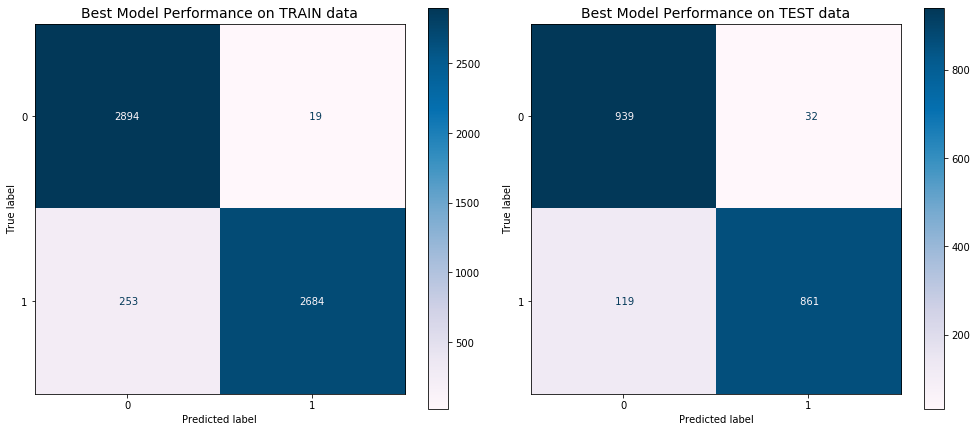

In [58]:
fig = plt.figure(figsize=(14,6))
#fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
plot_confusion_matrix(best_cvlr_model, X_train, y_train, 
#                      display_labels=X_test.columns, 
                      cmap="PuBu", 
                      values_format='4g', ax=ax1);
#plt.title("Best CVec+LogReg on TRAIN data",fontsize=14)
plt.title("Best Model Performance on TRAIN data",fontsize=14) # generate simple title for presentation

ax2 = fig.add_subplot(1,2,2)
plot_confusion_matrix(best_cvlr_model, X_test, y_test, 
#                      display_labels=X_test.columns, 
                      cmap="PuBu", 
                      values_format='4g', ax=ax2);
#plt.title("Best CVec+LogReg on TEST data",fontsize=14)
plt.title("Best Model Performance on TEST data",fontsize=14) # generate simple title for presentation
sup_str = 'Confusion Matrix for 1={double_dictionary[1]} and 0={double_dictionary[0]}'
print(f'Confusion Matrix for 1={double_dictionary[1]} and 0={double_dictionary[0]}')
plt.tight_layout();

## Conclusions

In conclusion, the 4 models built and evaluated

 - CountVectorizer + LogisticRegression
 - TfidfVectorizer + LogisticRegression
 - CountVectorizer + MultinomialNB (Naive Bayes)
 - TfidfVectorizer + SVC (Support Vector Classifier)
    
all performed similarly, correctly predicting the post ~92% of the time. This is a significant improvement over the baseline model of 50% correct predictions.

Given that the models are doing a good job of predicting, the features and coefficients of the LogisticRegression models can be explored to see if there are any insights into the differences between these 2 groups.

The top words for both games consist primarily of settings and game mechanics. For each game, the words that stood out most to me were
 - **Call of Duty**
  - **remastered** -- one of the Modern Warfare editions is being remastered; XBOX version is already out and PS3 is expected in less than a month
  - **opinion**
  
 - **Dungeons and Dragons**
  - **art** -- there were many posts that amounted to "look at this art!" and several along the lines of "I'm bored in quarantine, would you like me to make some art for your character?"
  - **homebrew** -- this is a term akin to 'fan fiction' that refers to game related props or other items that are created by the players and not by the game designers

At this time, it is only speculation as to whether this is a consistent theme indicating higher creative energy in the DnD players. A follow-up study including more posts, excluding more give-away words, and possibly exploring semantics might allow additional inferences to be drawn.